In [159]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [160]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

1. Генерація часового ряду

In [161]:
T = np.arange(1, 101)

def generate_series(T):
    return 0.13 * np.cos(T / 7 + 3) + 0.08 * np.sin(T / 3 + 3) + 0.39 + 0.11 * np.sin(T / 3 + 10)

y = generate_series(T)
y

array([0.15800688, 0.11714209, 0.09477343, 0.09371944, 0.11468009,
       0.15614782, 0.21455726, 0.2846573 , 0.36006517, 0.4339419 ,
       0.49971545, 0.55177231, 0.58604241, 0.60041329, 0.59492884,
       0.57175135, 0.53489171, 0.48973814, 0.44243593, 0.39918695,
       0.36554672, 0.34579658, 0.34246062, 0.35602069, 0.38486101,
       0.42544856, 0.4727293 , 0.5206965 , 0.56306832, 0.59399977,
       0.60875019, 0.60423236, 0.57938217, 0.53530756, 0.47519974,
       0.4040157 , 0.32796633, 0.25386584, 0.18841328, 0.13748487,
       0.10551411, 0.09502765, 0.10638735, 0.13776664, 0.18536326,
       0.24382499, 0.3068411 , 0.36783455, 0.4206787 , 0.46035975,
       0.48351238, 0.48876974, 0.47688983, 0.45064489, 0.41448632,
       0.37402281, 0.33536979, 0.3044423 , 0.28627005, 0.28441058,
       0.30052596, 0.33417005, 0.3828106 , 0.44208418, 0.50625627,
       0.56883649, 0.62328138, 0.66370772, 0.68553794, 0.68600661,
       0.6644723 , 0.62250015, 0.56370606, 0.49337902, 0.41792

2. Формування навчальної вибірки методом «вікон»


In [162]:
n, m = 9, 1
def make_windows(series, n, m=1, step=1):
    X, Y = [], []
    for i in range(len(series)-n-m+1):
        X.append(series[i:i+n])
        Y.append(series[i+n:i+n+m])
    return np.array(X), np.array(Y)

X, Y = make_windows(y, n, m)
print("Кількість зразків:", len(X))

Кількість зразків: 91


3. Розподіл вибірки на навчальну (ОВ) і контрольну (КВ)

In [163]:
test_frac = 0.2

M = int(round(len(X) * test_frac))

X_train, Y_train = X[:-M], Y[:-M]
X_val, Y_val = X[-M:], Y[-M:]

print("ОВ:", X_train.shape)
print("КВ:", X_val.shape)

ОВ: (73, 9)
КВ: (18, 9)


4. Побудова та навчання моделі


In [172]:
hidden_neurons = 2
model = Sequential()
model.add(Dense(hidden_neurons, activation='tanh', input_shape=(n,)))
model.add(Dense(m))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.02), loss='mse')

final_loss=1.0
all_train_mse=[]
all_val_mse=[]
all_epochs = []
n_epochs = 100
history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=n_epochs, verbose=0)

while final_loss > 0.001:
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=n_epochs, verbose=0)

    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    all_train_mse.append(train_loss)
    all_val_mse.append(val_loss)
    all_epochs.append(n_epochs)

    final_loss = val_loss
    print(f"Epochs: {n_epochs} | Train MSE: {train_loss:.5f} | Val MSE: {val_loss:.5f}")
    n_epochs += 50

Epochs: 100 | Train MSE: 0.01192 | Val MSE: 0.01494
Epochs: 150 | Train MSE: 0.00251 | Val MSE: 0.00522
Epochs: 200 | Train MSE: 0.00179 | Val MSE: 0.00358
Epochs: 250 | Train MSE: 0.00125 | Val MSE: 0.00251
Epochs: 300 | Train MSE: 0.00073 | Val MSE: 0.00159
Epochs: 350 | Train MSE: 0.00034 | Val MSE: 0.00081


5. Візуалізація результатів


In [174]:
# Побудуйте графік вихідного ряду
# Побудуйте графік зміни помилки від епох
# Побудуйте графік прогнозу на контрольній вибірці

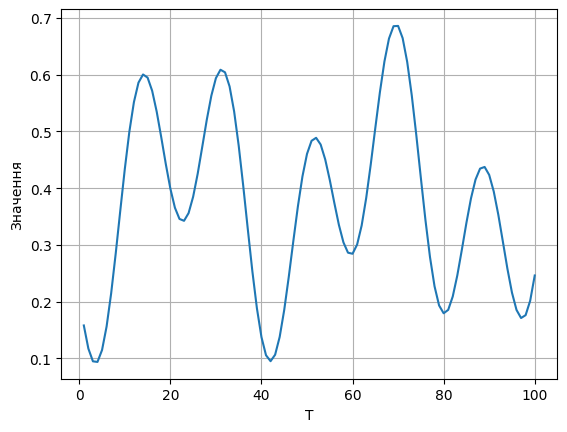

In [198]:
plt.plot(T, y)
plt.xlabel("T")
plt.ylabel("Значення")
plt.grid(True)
plt.show()

In [176]:
Y_pred = model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


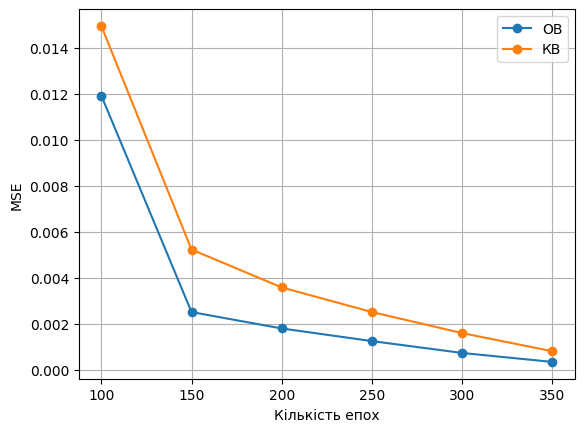

In [178]:
plt.plot(all_epochs, all_train_mse, marker='o', label='ОВ')
plt.plot(all_epochs, all_val_mse, marker='o', label='КВ')
plt.xlabel("Кількість епох")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

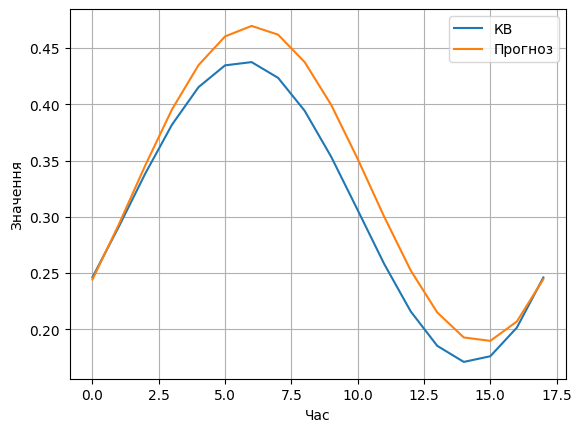

In [201]:
plt.plot(range(len(Y_val)), Y_val, label="КВ")
plt.plot(range(len(Y_val)), Y_pred, label="Прогноз")
plt.xlabel("Час")
plt.ylabel("Значення")
plt.grid(True)
plt.legend()
plt.show()

In [202]:
print(f"Початкова помилка навчання ОВ:  {all_train_mse[0]:.4f}")
print(f"Кінцева помилка навчання ОВ:    {all_train_mse[-1]:.4f}")
print(f"Початкова помилка навчання КВ:  {all_val_mse[0]:.4f}")
print(f"Кінцева помилка навчання КВ:    {all_val_mse[-1]:.4f}")

Початкова помилка навчання ОВ:  0.0119
Кінцева помилка навчання ОВ:    0.0003
Початкова помилка навчання КВ:  0.0149
Кінцева помилка навчання КВ:    0.0008
